# First trajectory-optimization problems
This notebook drives you through simple trajectory optimization problems, considering only "kinematic" version i.e only motion variables (no forces or torques yet). 
We will first look at a problem where the trajectory is described by a sequence of configurations $[q_0 ... q_T]$, with the only constraints is to have them sufficiently closed to each other.
The we will look at a real integration, where each timestep is described by a configuration $q_t$, velocity $v_t$ and acceleration $a_t$ (all in the configuration space. 
This will allow us to formulate a proper contact constraint, even if only partially described from the motion point of view. 
The next notebook will drive us to complete version of the trajectory optimization problem, including forces, torques and complete contacts.



In [ ]:
import gepetuto.magic

## Set up

We will use the following tools:
- the ur10 model (loaded by example-robot-data)
- pinocchio.casadi for writing the problem and computing its derivatives
- the IpOpt solver wrapped in casadi
- the meshcat viewer

In [ ]:
# %load tp2/generated/trajopt_kine_imports
import time
import casadi
import example_robot_data as robex
import numpy as np
import pinocchio as pin
from pinocchio import casadi as cpin
from wan2024.meshcat_viewer_wrapper import MeshcatVisualizer


The notebook is written first for a UR10 robot model configured in fixed basis, then with a Talos pair of legs configured in floating mode. Replace the robot by your own URDF...

In [ ]:
robot = robex.load("ur10")

The robot will start from an arbitrary initial configuration (make the solver life simpler by avoiding the singular 0 configuration) and aim at an object located a placement $M_{target} \in SE(3)$

In [ ]:
# %load tp2/generated/trajopt_kine_configurations
in_world_M_target = pin.SE3(pin.utils.rotate("y", 3), np.array([-0.5, 0.1, 0.2]))  # x,y,z
q0 = np.array([0, -3.14 / 2, 0, 0, 0, 0])
tool_frameName = "tool0"


Open a viewer, display the robot and markers to visualize

In [ ]:
# %load tp2/generated/trajopt_kine_viewer
# Open the viewer
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)
# Add a vizualization for the target
boxID = "world/box"
viz.addBox(boxID, [0.05, 0.1, 0.2], [1.0, 0.2, 0.2, 0.5])
# Add a vizualisation for the tip of the arm.
tipID = "world/blue"
viz.addBox(tipID, [0.08] * 3, [0.2, 0.2, 1.0, 0.5])

def displayScene(q, dt=1e-1):
    """
    Given the robot configuration, display:
    - the robot
    - a box representing tool_id
    - a box representing in_world_M_target
    """
    pin.framesForwardKinematics(model, data, q)
    M = data.oMf[tool_id]
    viz.applyConfiguration(boxID, in_world_M_target)
    viz.applyConfiguration(tipID, M)
    viz.display(q)
    time.sleep(dt)


In [ ]:
viz.viewer.jupyter_cell()

We are mostly interested by the robot model. We also need to access some particular frames.

In [ ]:
# %load tp2/generated/trajopt_kine_modeldata
robot.q0 = q0

# The pinocchio model is what we are really interested by.
model = robot.model
data = model.createData()
tool_id = model.getFrameId(tool_frameName)


Finally, we will need the same helpers for getting around the Casadi SX/MX issue.

In [ ]:
# %load tp2/generated/trajopt_kine_casadi
# --- Casadi helpers
cmodel = cpin.Model(model)
cdata = cmodel.createData()

cq = casadi.SX.sym("x", model.nq, 1)
cpin.framesForwardKinematics(cmodel, cdata, cq)

error3_tool = casadi.Function(
    "etool3", [cq], [cdata.oMf[tool_id].translation - in_world_M_target.translation]
)
error6_tool = casadi.Function(
    "etool6",
    [cq],
    [cpin.log6(cdata.oMf[tool_id].inverse() * cpin.SE3(in_world_M_target)).vector],
)
error_tool = error3_tool


We are done for the set up, let's now write the problems we are interested by.

## Optimizing a sequence of configurations

We will first consider a problem where the trajectory is represented by a sequence of configurations.

Decide: $Q = [ q_0 ... q_T ] \in R^{n_q \times (T+1)}$

Minimizing:   $\sum_{t=0}^{T-1}  || q_t - q_{t+1} ||^2 + || e(q_T) ||^2$

Subject to: $q_0 = robot.q0$

The hyperparameters for this problems are:

In [ ]:
# %load tp2/generated/trajopt_kine_hyper
T = 10
w_run = 0.1
w_term = 1


For that, we first define an optimization problem in Casadi where the decision variables are the T+1 configurations.

In [ ]:
# %load tp2/generated/trajopt_kine_casadi_opti
opti = casadi.Opti()
var_qs = [opti.variable(model.nq) for t in range(T + 1)]
totalcost = 0


Now implement the running cost (the sum of configuration differences):

In [ ]:
# %load tp2/generated/trajopt_kine_casadi_runcost
for t in range(T):
    totalcost += w_run * casadi.sumsqr(var_qs[t] - var_qs[t + 1])


Now implement the terminal cost. You can use either the 3d cost (position only) or 6d cost (full placement).

In [ ]:
# %load tp2/generated/trajopt_kine_casadi_termcost
totalcost += w_term * casadi.sumsqr(error_tool(var_qs[T]))


Now implement the initial constraint.

In [ ]:
# %load tp2/generated/trajopt_kine_casadi_q0
opti.subject_to(var_qs[0] == robot.q0)


And we are good for optimizing the problem:

In [ ]:
# %load tp2/generated/trajopt_kine_solve
opti.minimize(totalcost)
opti.solver("ipopt")  # set numerical backend
opti.callback(lambda i: displayScene(opti.debug.value(var_qs[-1])))

# Caution: in case the solver does not converge, we are picking the candidate values
# at the last iteration in opti.debug, and they are NO guarantee of what they mean.
try:
    sol = opti.solve_limited()
    sol_qs = [opti.value(var_q) for var_q in var_qs]
except:
    print("ERROR in convergence, plotting debug info.")
    sol_qs = [opti.debug.value(var_q) for var_q in var_qs]


Here the progress of the solver is shown by displaying the terminal configuration in the viewer at each new step. We can also visualize the full trajectory.

In [ ]:
# %load tp2/generated/trajopt_kine_disptraj
def displayTraj(qs, dt=1e-2):
    for q in qs[1:]:
        displayScene(q, dt=dt)


In [ ]:
displayTraj(sol_qs,1e-1)

## Optimization with proper integration

So far, we represented the trajectory with a collection of configurations. The regularization $|| q-q'||^2$ can be interpreted as a regularization on the velocity, and extended to higher level differenciation. This is the approach explored in eg the excellent tutorial by [Marc Toussaint (2017)](https://argmin.lis.tu-berlin.de/papers/17-toussaint-Newton.pdf). Going in that direction, you might want to represent your trajectory by a proper polynomials, which would make your derivatives more stable, then leading to collocation.

We will go another way. The drawback of $|| q-q'||^2$ and further derivatives is that it is not Markovian any more (you might formulated a 2nd-order Markovian). For Casadi and the backend solver IpOpt behind it, it makes no importance as they are not able to exploit the Markovian structure. But other efficient solvers, in particular based on Belman recursivity, are able to exploit this structure for improved computation speed.

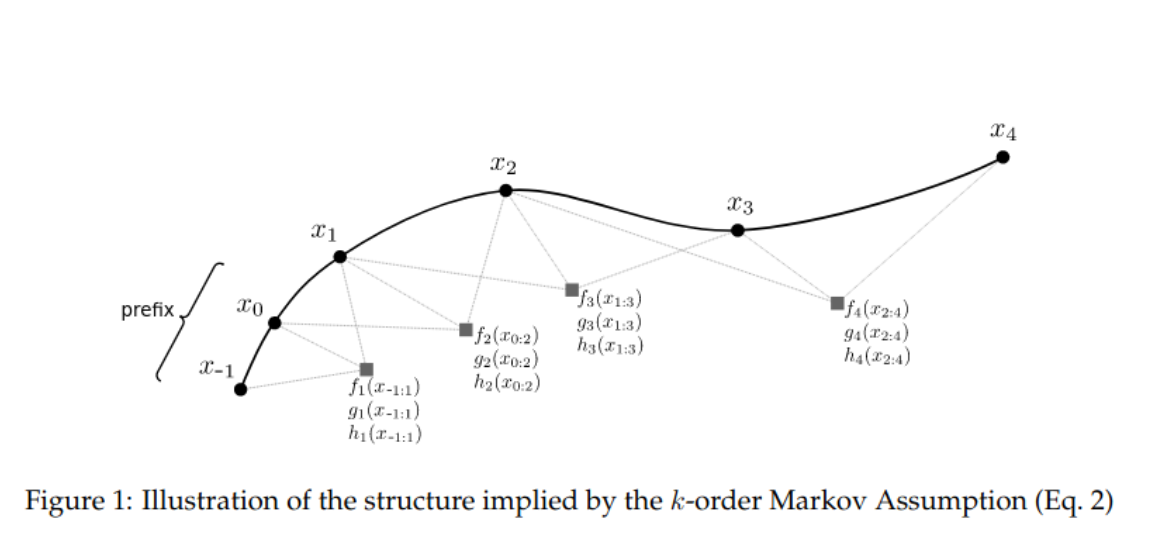

Marc Toussaint (2017). A tutorial on Newton methods for constrained trajectory optimization and relations to SLAM, Gaussian Process smoothing, optimal control, and probabilistic inference. Geometric and numerical foundations of movements, 361-392.


We will then represent the trajectory by a list $X=[x_0...x_T]$ of state points combining configuration and velocity $x=[q,v]$, and a list of accelerations $A = [a_0 ... a_{T-1}$ (all of them in configuration space.

In [ ]:
# %load tp2/generated/trajopt_acc_helpers
# --- Casadi helpers
cmodel = cpin.Model(model)
cdata = cmodel.createData()

nq = model.nq
nv = model.nv
nx = nq + nv
ndx = 2 * nv
cx = casadi.SX.sym("x", nx, 1)
cdx = casadi.SX.sym("dx", nv * 2, 1)
cq = cx[:nq]
cv = cx[nq:]
caq = casadi.SX.sym("a", nv, 1)

# Compute kinematics casadi graphs
cpin.forwardKinematics(cmodel, cdata, cq, cv, caq)
cpin.updateFramePlacements(cmodel, cdata)


We need to redefine the forward geometry helper for $x$.

In [ ]:
# %load tp2/generated/trajopt_acc_error
# Sym graph for the operational error
error_tool = casadi.Function(
    "etool3", [cx], [cdata.oMf[tool_id].translation - in_world_M_target.translation]
)


We must then enforce these variables to be derivatives of each other. This is done by introducing a numerical integration, for example:
$$ v_{t+1} = v_t + a_t \Delta T$$
$$ q_{t+1} = q_t \oplus v_{t+1} \Delta T$$

For now, the configuration space is simple, and we don't have to worry on the sum in $\mathcal{Q}$, more on this later: for now, it is a regular plus. 

Here we use the basic Euler integration scheme, but any other scheme (Runge-Kutta, etc) can be chosen. We will suppose that it is explicit, ie $x'$ is a litteral of $x,a$. Roboticists don't pay much attention to the integration scheme, in part because they are lazy, but also because nobody shown a convincing proof of the superiority of better integrators for our setups. 

The optimization problem then is


Decide: 
- $\{x\} = [x_0 ... x_T]$ the state trajectory
- $\{a\} = [a_0 ... a_{T-1}]$ the acceleration

Minimizing:  \sum_{t=0}^{T-1} v_t^2 + || e(q) ||^2

Subject to:
- $q_0 = robot.q0$
- $\forall t=0..T-1, $
$$\quad\quad\quad\quad v_{t+1} = v_t + a_t \Delta T$$
$$\quad\quad\quad\quad q_{t+1} = q_t \oplus v_{t+1} \Delta T$$

The following hyperparameters are useful:


In [ ]:
# %load tp2/generated/trajopt_acc_hyper
T = 50
DT = 0.002
w_vel = 0.1
w_conf = 5



This integration scheme is summarized with the following casadi helper.


In [ ]:
# %load tp2/generated/trajopt_acc_cnext
# Sym graph for the integration operation x' = [ q+vDT+aDT**2, v+aDT ]
cnext = casadi.Function(
    "next",
    [cx, caq],
    [
        casadi.vertcat(
            cpin.integrate(cmodel, cx[:nq], cx[nq:] * DT + caq * DT**2),
            cx[nq:] + caq * DT,
        )
    ],
)


From that, you can define the trajectory optimization problem. Follow the steps:

1. Define the variables $\{x\}$ and $\{a\}$

In [ ]:
opti = casadi.Opti()
var_xs = [opti.variable(nx) for t in range(T + 1)]
var_as = [opti.variable(nv) for t in range(T)]

2. Compute the cost

In [ ]:
# %load tp2/generated/trajopt_acc_ocp2
totalcost = 0
# Define the running cost
for t in range(T):
    totalcost += 1e-3 * DT * casadi.sumsqr(var_xs[t][nq:])
    totalcost += 1e-4 * DT * casadi.sumsqr(var_as[t])
totalcost += 1e4 * casadi.sumsqr(error_tool(var_xs[T]))


3. Enforce the initial condition

In [ ]:
# %load tp2/generated/trajopt_acc_ocp3
opti.subject_to(var_xs[0][:nq] == robot.q0)
opti.subject_to(var_xs[0][nq:] == 0)


4. Enforce the integration scheme

In [ ]:
# %load tp2/generated/trajopt_acc_integration
for t in range(T):
    opti.subject_to(cnext(var_xs[t], var_as[t]) == var_xs[t + 1])


5. Solve

In [ ]:
# %load tp2/generated/trajopt_acc_ocp5
### SOLVE
opti.minimize(totalcost)
opti.solver("ipopt")  # set numerical backend
opti.callback(lambda i: displayScene(opti.debug.value(var_xs[-1][:nq])))

# Caution: in case the solver does not converge, we are picking the candidate values
# at the last iteration in opti.debug, and they are NO guarantee of what they mean.
try:
    sol = opti.solve_limited()
    sol_xs = [opti.value(var_x) for var_x in var_xs]
    sol_as = [opti.value(var_a) for var_a in var_as]
except:
    print("ERROR in convergence, plotting debug info.")
    sol_xs = [opti.debug.value(var_x) for var_x in var_xs]
    sol_as = [opti.debug.value(var_a) for var_a in var_as]


In [ ]:
# %load tp2/generated/trajopt_acc_ocp6
print("***** Display the resulting trajectory ...")
displayScene(robot.q0, 1)
displayTraj([x[:nq] for x in sol_xs], DT)

## Enforcing a contact constraint

The second problem we defined is actually very similar to the first one. It is a simple reformulation, but the optimum is the same. But now we can nicely enforce acceleration constraints, or set acceleration costs, which is very useful for dynamics.

As a first step, let's enforce a contact constraint. 

Rigid (bilateral) contacts lead to a motion constraint imposing a geometry quantity to remain constant: either the position of a contact point in a 3D contact, or the relative placements of the contact bodies for 6D contact, etc. 

But first, for that to be meaningul, let's do it on a humanoid robot.

### Load a biped model

In [ ]:
# %load tp2/generated/trajopt_acc_talos
robot = robex.load("talos_legs")
# Open the viewer
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)

# The pinocchio model is what we are really interested by.
model = robot.model
data = model.createData()


In addition to the usual end-effector frame, we will now define some contact location of the robot body. We will consider 2 contact types: punctual 3d contacts, and flat 6d contacts. They are defined by their type, and the frame of the robot where the contact occurs. We will store this information using the SimpleNamespace type.

In [ ]:
from types import SimpleNamespace

In [ ]:
# %load tp2/generated/trajopt_acc_frames
in_world_M_target = pin.SE3(pin.utils.rotate("y", 3), np.array([-0.1, 0.2, 0.45094]))  # x,y,z
contacts = [SimpleNamespace(name="left_sole_link", type=pin.ContactType.CONTACT_6D)]
tool_frameName = "right_sole_link"


In [ ]:
# %load tp2/generated/trajopt_acc_framesId
tool_id = model.getFrameId(tool_frameName)
for c in contacts:
    c.id = model.getFrameId(c.name)
    assert c.id < len(model.frames)


We can display them in the viewer for more understanding.

In [ ]:
# %load tp2/generated/trajopt_acc_viz
# --- Add box to represent target
# Add a vizualization for the target
boxID = "world/box"
viz.addBox(boxID, [0.05, 0.1, 0.2], [1.0, 0.2, 0.2, 0.5])
# Add a vizualisation for the tip of the arm.
tipID = "world/blue"
viz.addBox(tipID, [0.08] * 3, [0.2, 0.2, 1.0, 0.5])
for c in contacts:
    c.viz = f"world/contact_{c.name}"
    viz.addSphere(c.viz, [0.07], [0.8, 0.8, 0.2, 0.5])


def displayScene(q, dt=1e-1):
    """
    Given the robot configuration, display:
    - the robot
    - a box representing tool_id
    - a box representing in_world_M_target
    """
    pin.framesForwardKinematics(model, data, q)
    M = data.oMf[tool_id]
    viz.applyConfiguration(boxID, in_world_M_target)
    viz.applyConfiguration(tipID, M)
    for c in contacts:
        viz.applyConfiguration(c.viz, data.oMf[c.id])
    viz.display(q)
    time.sleep(dt)


def displayTraj(qs, dt=1e-2):
    for q in qs[1:]:
        displayScene(q, dt=dt)


displayScene(robot.q0)


### Working with a floating robot (ie on a Lie group)

This robot has a more complex configuration structure, with the rotation of its basis represented by a quaternion (dimension 4) subject to normalization constraint, and the velocity of its basis with an angular velocity (dimension 3). Then $n_q>n_v$, and we cannot trivally sum $q \oplus v \Delta t$.

In [ ]:
# %load tp2/generated/trajopt_acc_helpers
# --- Casadi helpers
cmodel = cpin.Model(model)
cdata = cmodel.createData()

nq = model.nq
nv = model.nv
nx = nq + nv
ndx = 2 * nv
cx = casadi.SX.sym("x", nx, 1)
cdx = casadi.SX.sym("dx", nv * 2, 1)
cq = cx[:nq]
cv = cx[nq:]
caq = casadi.SX.sym("a", nv, 1)

# Compute kinematics casadi graphs
cpin.forwardKinematics(cmodel, cdata, cq, cv, caq)
cpin.updateFramePlacements(cmodel, cdata)


This $\oplus$ operation is the integration on the configuration space, formally a Lie group, and is implemented in pinocchio with pin.integrate(model,q,dq). The following Casadi helper synthesizes this information:

In [ ]:
# %load tp2/generated/trajopt_acc_integrate
# Sym graph for the integration operation x,dx -> x(+)dx = [model.integrate(q,dq),v+dv]
cintegrate = casadi.Function(
    "integrate",
    [cx, cdx],
    [casadi.vertcat(cpin.integrate(cmodel, cx[:nq], cdx[:nv]), cx[nq:] + cdx[nv:])],
)


You can set up the optimization variables to contain a configuration $q$, but in that case you must enforce the normalization constraint $q[4:7] == 1$. More efficiently, we represent the decision variable to be $dq \in R^{n_v}$ a small displacement from the robot reference configuration robot.q0. Then $q = robot.q0 \oplus dq$ becomes a function of the decision variable, and no constraint need to be additionally enforce. The nice aspect of Casadi is that you can define e.g var_dq to be your decision variable, then call var_q the integration of $dq$ from robot.q0, and use var_q as if it was you variable for the simple robot case. More about that in practice later.

The optimization problem can now be written:

Decide:
- $\{x\} = [ x_0 ... x_T ]$ the state trajectory (with $x = (robot.q0 + dq, v)$)
- $\{a\} = [a_0 ... a_{T-1} ]$ the accelerations

Minimizing: $\sum_{t=0}^{T-1} v_t^2 + e(q_T)^2$

Subject to:
- $x_0 = (robot.q0, 0)$
- $\forall t=0..T-1$
$$ v_{t+1} = v_t + a_t \Delta t$$
$$ q_{t+1} = q_t \oplus v_{t+1} \Delta t$$
$$ \forall c  \textrm{ contacts }, \alpha_c{t} (q_t,v_t,a_t) = \kappa$$

where $\alpha$ is the acceleration of the contact interfaces, and $\kappa$ is a numerical trick we will explain below.

Before that, let's write the helpers needed to go around the SX/MX Casadi typing.

In [ ]:
# %load tp2/generated/trajopt_acc_error
# Sym graph for the operational error
error_tool = casadi.Function(
    "etool3", [cx], [cdata.oMf[tool_id].translation - in_world_M_target.translation]
)


In [ ]:
# %load tp2/generated/trajopt_acc_cnext
# Sym graph for the integration operation x' = [ q+vDT+aDT**2, v+aDT ]
cnext = casadi.Function(
    "next",
    [cx, caq],
    [
        casadi.vertcat(
            cpin.integrate(cmodel, cx[:nq], cx[nq:] * DT + caq * DT**2),
            cx[nq:] + caq * DT,
        )
    ],
)


### Contact model



Contacts are then mathematically defined by a forward geometry function to remain constant: the world position of a point for 3D contacts, the relative placement of two frames for 6D contacts. 

As we formulate the problem in accelerations, we will rather differentiate twice this constraint to have it at the acceleration level. This is more generic, and assuming you start from a state with a valid contact configuration, then it is leading to respecting the initial constraint as well.


In [ ]:
# %load tp2/generated/trajopt_acc_helper_contact
# Sym graph for the contact constraint and Baugart correction terms
# Works for both 3D and 6D contacts.
# Uses the contact list <contacts> where each item must have a <name>, an <id> and a <type> field.
dpcontacts = {}  # Error in contact position
vcontacts = {}  # Error in contact velocity
acontacts = {}  # Contact acceleration

for c in contacts:
    if c.type == pin.ContactType.CONTACT_3D:
        p0 = data.oMf[c.id].translation.copy()
        dpcontacts[c.name] = casadi.Function(
            f"dpcontact_{c.name}",
            [cx],
            [-(cdata.oMf[c.id].inverse().act(casadi.SX(p0)))],
        )
        vcontacts[c.name] = casadi.Function(
            f"vcontact_{c.name}",
            [cx],
            [cpin.getFrameVelocity(cmodel, cdata, c.id, pin.LOCAL).linear],
        )
        acontacts[c.name] = casadi.Function(
            f"acontact_{c.name}",
            [cx, caq],
            [cpin.getFrameClassicalAcceleration(cmodel, cdata, c.id, pin.LOCAL).linear],
        )
    elif c.type == pin.ContactType.CONTACT_6D:
        p0 = data.oMf[c.id]
        dpcontacts[c.name] = casadi.Function(f"dpcontact_{c.name}", [cx], [np.zeros(6)])
        vcontacts[c.name] = casadi.Function(
            f"vcontact_{c.name}",
            [cx],
            [cpin.getFrameVelocity(cmodel, cdata, c.id, pin.LOCAL).vector],
        )
        acontacts[c.name] = casadi.Function(
            f"acontact_{c.name}",
            [cx, caq],
            [cpin.getFrameAcceleration(cmodel, cdata, c.id, pin.LOCAL).vector],
        )


Yet in practice, we barely get perfect 0 contact acceleration (because nonexactness of the numerical optimization), and we don't have a perfect numerical integrator. Both lead to some drift in the contact interface. We then have to correct this nonphysical drift with a nonphysical corrector, asking the acceleration to follow the corrector $\kappa$. The simplest solution is the so-called Baumgart correction term, which is a simple linear feedback in both contact position and velocity.

$$ \kappa(q,v) = -K_p (p(q) \ominus p_0) - K_v \nu$$

where $p(q)$ is the contact location, that should be constant to $p_0$, and $\nu$ is the contact velocity, $K_p,K_v$ are the feedback gains typically chosen so that $K_p = 2\sqrt{K_v}$.

In [ ]:
# %load tp2/generated/trajopt_acc_Baumgart
Kp = 200
Kv = 2 * np.sqrt(Kp)

In [ ]:
# %load tp2/generated/trajopt_acc_contact_placement
# Get initial contact position (for Baumgart correction)
pin.framesForwardKinematics(model, data, robot.q0)

In [ ]:
# %load tp2/generated/trajopt_acc_corrector
cbaumgart = {
    c.name: casadi.Function(
        f"K_{c.name}", [cx], [Kp * dpcontacts[c.name](cx) + Kv * vcontacts[c.name](cx)]
    )
    for c in contacts
}

### Writing the final problem
You can now write the full problem, following the steps.

1. Declare the $X$ and $A$ variables. Remember $X$ is written in the tangent, first as $var_dxs$ where each step is of size $n_{dx} = 2 n_v$, then as $var_xs$ by integrating (cintegrate) from the state $robot.q0,0$.

In [ ]:
# %load tp2/generated/trajopt_acc_ocp1
opti = casadi.Opti()
var_dxs = [opti.variable(ndx) for t in range(T + 1)]
var_as = [opti.variable(nv) for t in range(T)]
var_xs = [
    cintegrate(np.concatenate([robot.q0, np.zeros(nv)]), var_dx) for var_dx in var_dxs
]


2. Compute the cost by summing the integration terms and the terminal cost.

In [ ]:
# %load tp2/generated/trajopt_acc_ocp2
totalcost = 0
# Define the running cost
for t in range(T):
    totalcost += 1e-3 * DT * casadi.sumsqr(var_xs[t][nq:])
    totalcost += 1e-4 * DT * casadi.sumsqr(var_as[t])
totalcost += 1e4 * casadi.sumsqr(error_tool(var_xs[T]))


3. Enforce the initial constraint

In [ ]:
# %load tp2/generated/trajopt_acc_ocp3
opti.subject_to(var_xs[0][:nq] == robot.q0)
opti.subject_to(var_xs[0][nq:] == 0)


4. Enforce the integration constraint 

In [ ]:
# %load tp2/generated/trajopt_acc_integration
for t in range(T):
    opti.subject_to(cnext(var_xs[t], var_as[t]) == var_xs[t + 1])


5. Enforce the contact constraint (first without correction, then with correction)

In [ ]:
# %load tp2/generated/trajopt_acc_ocp4
# Define the contact constraints
for t in range(T):
    for c in contacts:
        # correction = Kv* vcontacts[c.name](var_xs[t]) + Kp * dpcontacts[c.name](var_xs[t])
        correction = cbaumgart[c.name](var_xs[t])
        opti.subject_to(acontacts[c.name](var_xs[t], var_as[t]) == -correction)


6. Solve

In [ ]:
# %load tp2/generated/trajopt_acc_ocp5
### SOLVE
opti.minimize(totalcost)
opti.solver("ipopt")  # set numerical backend
opti.callback(lambda i: displayScene(opti.debug.value(var_xs[-1][:nq])))

# Caution: in case the solver does not converge, we are picking the candidate values
# at the last iteration in opti.debug, and they are NO guarantee of what they mean.
try:
    sol = opti.solve_limited()
    sol_xs = [opti.value(var_x) for var_x in var_xs]
    sol_as = [opti.value(var_a) for var_a in var_as]
except:
    print("ERROR in convergence, plotting debug info.")
    sol_xs = [opti.debug.value(var_x) for var_x in var_xs]
    sol_as = [opti.debug.value(var_a) for var_a in var_as]

And finally display the result.

In [ ]:
# %load tp2/generated/trajopt_acc_ocp6
print("***** Display the resulting trajectory ...")
displayScene(robot.q0, 1)
displayTraj([x[:nq] for x in sol_xs], DT)

We can visualize the contact constraint by displaying the small displacement of the foot during the motion. It is not perfect, but still quite acceptable. Yet we reached the limit of Casadi+IpOpt, it is time to move to Crocoddyl.

In [ ]:
# %load tp2/generated/trajopt_acc_plot
# Plotting the contact gaps
h_pcontacts = []
h_vcontacts = []
h_acontacts = []
for t in range(T):
    x = sol_xs[t]
    q = x[:nq]
    v = x[nq:]
    a = sol_as[t]
    h_pcontacts.append(
        np.concatenate([opti.value(dpcontacts[c.name](var_xs[t])) for c in contacts])
    )
    h_vcontacts.append(
        np.concatenate([opti.value(vcontacts[c.name](var_xs[t])) for c in contacts])
    )
    h_acontacts.append(
        np.concatenate(
            [opti.value(acontacts[c.name](var_xs[t], var_as[t])) for c in contacts]
        )
    )


import matplotlib.pylab as plt

plt.ion()
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(h_pcontacts)
ax[0].set_title("delta position")
ax[0].axis((-2.45, 51.45, -0.5e-3, 0.5e-3))
ax[1].plot(h_vcontacts)
ax[1].set_title("velocity")
ax[1].axis((-2.45, 51.45, -0.006627568040194312, 0.007463128239663308))
